In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import pickle
import networkx as nx
import random
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import metrics, model_selection, preprocessing
import warnings
import gc
warnings.filterwarnings("ignore")
random.seed(32)
np.random.seed(32)


def AUPR(lables, pred):
    precision, recall, _thresholds = metrics.precision_recall_curve(
        lables, pred),
    aupr = metrics.auc(recall, precision)
    return aupr


def roc(fpr, tpr, savePath="./roc.jpg"):
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Validation')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(savePath)
    plt.show()


def all_metric(model, X_test, y_test):
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    print("roc_auc:{}".format(roc_auc))
    accuracy = accuracy_score(y_test, y_predict)
    print("accuracy:{}".format(accuracy))
    f1 = metrics.f1_score(y_test, y_predict)
    print("f1:{}".format(f1))
    precision = precision_score(y_test, y_predict)
    print("precision:{}".format(precision))
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率
    print("recall:{}".format(recall))
    return fpr, tpr


def run_embedding(model, train_data_file, representation_size=128, test_size=0.2):
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    # evaluate predictions
    fpr, tpr = all_metric(model, X_test, y_test)
    del train_data, X, Y, X_train, X_test, y_train, y_test
    count=gc.collect()
    return fpr, tpr


def run(model, X, Y, test_size=0.2):
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    fpr, tpr = all_metric(model, X_test, y_test)
    del train_data, X, Y, X_train, X_test, y_train, y_test
    count=gc.collect()
    return fpr, tpr

# 读取文件中的正负边


def read_edges(filename):
    pos_edges = set()
    neg_edges = set()
    with open(filename, 'r') as f:
        for line in f:
            words = line.split()
            node1 = words[0]
            node2 = words[1]
            label = words[2]
            if label == '1':
                pos_edges.add((node1, node2))
            else:
                neg_edges.add((node1, node2))
    return list(pos_edges), list(neg_edges)


def read_embeddings(embedding_file):
    embeddings = {}
    with open(embedding_file, 'r') as f:
        first_line = f.readline()
        node_nums, dimension = first_line.split()
        #print("{} {}".format(node_nums,dimension))
        for line in f:
            line = line.split()
            embeddings[line[0]] = line[1:]
    return embeddings, int(dimension)


def get_embedding_features(embedding_file, pos_edges, neg_edges):
    embeddings, embedding_dimension = read_embeddings(embedding_file)
    # 边的特征
    # 提取正例特征
    pos_embedding_features = []
    label = []
    for edge in pos_edges:
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        # print(edge)
        pos_embedding_features.append(
            np.hstack((embeddings[disease_id], embeddings[gene_id])))
        label.append(1)

    # 提取负例特征
    neg_embedding_features = []
    for edge in neg_edges:
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        # print(edge)
        neg_embedding_features.append(
            np.hstack((embeddings[disease_id], embeddings[gene_id])))
        label.append(0)
    train_embedding_features = np.vstack(
        (pos_embedding_features, neg_embedding_features))
    return train_embedding_features

# 加载网络


def loadNet(fileName):
    edges = set()
    with open(fileName, 'r') as f:
        for line in f:
            words = line.split()
            edges.add((words[0], words[1]))
    return edges


def run_struct(model, train_data_file, feature_columns, test_size):
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    X = train_data[feature_columns]
    Y = train_data['label']
#     X = preprocessing.scale(X)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    fpr, tpr = all_metric(model, X_test, y_test)
    del train_data, X, Y, X_train, X_test, y_train, y_test
    count=gc.collect()
    return fpr, tpr


def extract_struct_feature(G, trainEdgeFile, savePath):
    degree = dict(G.degree())  # 返回所有节点的度
    # degree_connect=dict(degree_connect)
    centrality = nx.degree_centrality(G)
    cluster_coefficient = nx.clustering(G)
    pos_edges, neg_edges = read_edges(trainEdgeFile)

    pos_ra = list(nx.resource_allocation_index(G, pos_edges))
    pos_jc = list(nx.jaccard_coefficient(G, pos_edges))
    pos_aa = list(nx.adamic_adar_index(G, pos_edges))
    pos_pa = list(nx.preferential_attachment(G, pos_edges))
    # pos_cn=list(nx.common_neighbor_centrality (G,pos_edges)) #运行时间长
    # pos_rash=list(nx.ra_index_soundarajan_hopcroft(G,pos_edges))   需要社区信息
    # pos_wic=list(nx.within_inter_cluster(G,pos_edges)) 需要社区信息
    pos_ra_val = [val for node1, node2, val in pos_ra]
    pos_jc_val = [val for node1, node2, val in pos_jc]
    pos_pa_val = [val for node1, node2, val in pos_pa]
    pos_edge_feature = np.array([pos_ra_val, pos_jc_val, pos_pa_val]).T

    neg_ra = list(nx.resource_allocation_index(G, neg_edges))
    neg_jc = list(nx.jaccard_coefficient(G, neg_edges))
    neg_pa = list(nx.preferential_attachment(G, neg_edges))
    neg_ra_val = [val for node1, node2, val in neg_ra]
    neg_jc_val = [val for node1, node2, val in neg_jc]
    neg_pa_val = [val for node1, node2, val in neg_pa]
    neg_edge_feature = np.array([neg_ra_val, neg_jc_val, neg_pa_val]).T

    # 节点特征提取
    # 提取正例特征
    pos_node_features = []
    label = []
    for edge in pos_edges:
        feature = []
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        pos_node_features.append((degree[disease_id], degree[gene_id], centrality[disease_id],
                                  centrality[gene_id], cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
        label.append(1)
     # 提取负例特征
    neg_node_features = []
    for edge in neg_edges:
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        neg_node_features.append((degree[disease_id], degree[gene_id], centrality[disease_id],
                                  centrality[gene_id], cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
        label.append(0)

    pos_node_features = np.array(pos_node_features)
    pos_struct_features = np.hstack((pos_node_features, pos_edge_feature))
    neg_node_features = np.array(neg_node_features)
    neg_struct_features = np.hstack((neg_node_features, neg_edge_feature))
    struct_features = np.vstack((pos_struct_features, neg_struct_features))
    # 基于边的特征
    feature_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                       "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
    struct_train_data = pd.DataFrame(struct_features, columns=feature_columns)
    struct_train_data['label'] = label
    struct_train_data.to_csv(savePath, index=False)
    return struct_train_data

/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度

negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    train_data_file="train_data/all_connectiveSample_negPosRatio"+str(sampleRatio)+"_node2vec128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleNode2vec.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.885044445924612, 0.8968009922231239, 0.9044728813922294, 0.9049911595526333, 0.9115565588500993, 0.9113082410568444, 0.9075056766350692, 0.9048223338689348, 0.9029475190413587]
[0.8191082802547771, 0.8184597745079304, 0.8286194771441675, 0.8398726114649682, 0.8572832496178204, 0.8688133002102044, 0.8734499745201291, 0.87861183305305, 0.8818011257035647]
[0.8716558206796817, 0.8254959588537839, 0.7814388769740691, 0.7447715736040609, 0.7349422023930237, 0.7106427818756585, 0.6814878153056861, 0.651601579640193, 0.6272189349112426]


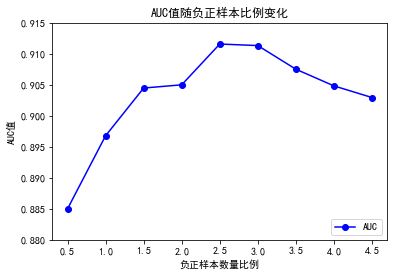

In [16]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.88, 0.915])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/node2vecNegSample_auc变化曲线.svg")
plt.show()

In [36]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度

negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    train_data_file="train_data/all_connectiveSample_negPosRatio"+str(sampleRatio)+"_deepwalk128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleDeepwalk.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.8875856568998111, 0.9003777735900323, 0.9012835323110506, 0.9028246320012452, 0.9063404549796122, 0.9071763603546465, 0.9088634682863121, 0.9008130213270655, 0.9092108301499146]
[0.8272611464968153, 0.8171221096885152, 0.8243387861183306, 0.8392356687898089, 0.8504040183446168, 0.8612650487292184, 0.8680142687277052, 0.8757070784283749, 0.8888888888888888]
[0.878101402373247, 0.822613531047266, 0.7729697688203913, 0.7491053677932406, 0.7228964401294499, 0.6978776529338327, 0.6758448060075094, 0.6540425531914893, 0.6444296197464976]


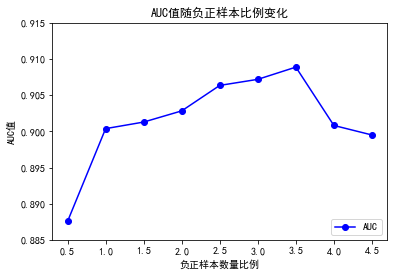

In [38]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.885, 0.915])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/deepwalkNegSample_auc变化曲线.svg")
plt.show()

In [19]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度

negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    train_data_file="train_data/all_connectiveSample_negPosRatio"+str(sampleRatio)+"_line128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleLine.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9532471554433837, 0.9579295064740354, 0.9607049268608685, 0.9572795757443301, 0.9620152234006194, 0.9655414738935539, 0.9611677122357475, 0.9587884401569143, 0.9589717289931684]
[0.8955414012738854, 0.8908847697305561, 0.8952759516893442, 0.8974522292993631, 0.9055470626774405, 0.9162048538123447, 0.9139629692542891, 0.9183611068643939, 0.9225210200819957]
[0.9239896180941788, 0.8908430510418658, 0.8699449401936588, 0.8426197458455523, 0.8347659980897804, 0.8296756651777044, 0.8021870728373364, 0.785024154589372, 0.7762392133253061]


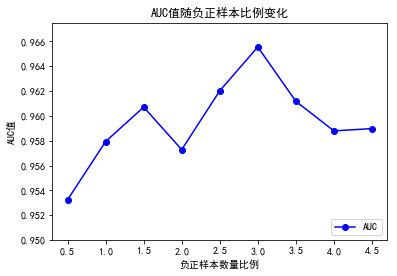

In [23]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.95, 0.9675])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/lineNegSample_auc变化曲线.svg")
plt.show()

In [24]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度

negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    train_data_file="train_data/all_connectiveSample_negPosRatio"+str(sampleRatio)+"_sdne128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleSDNE.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9099282503001307, 0.921758134882203, 0.9182599780756148, 0.9201030166185982, 0.923889954702982, 0.9275891272697264, 0.923484625911471, 0.9238780280013864, 0.9222519545635766]
[0.8425477707006369, 0.8396713166443722, 0.8359578046170311, 0.8489171974522293, 0.8671107228652544, 0.8793235237913243, 0.8799898080516392, 0.8896957651735209, 0.8936140643457716]
[0.8866471019809244, 0.8437907279836158, 0.7935347315759091, 0.7689010132501949, 0.7536935842946773, 0.7396413110698825, 0.70678564017431, 0.6914688903143039, 0.6740472642111988]


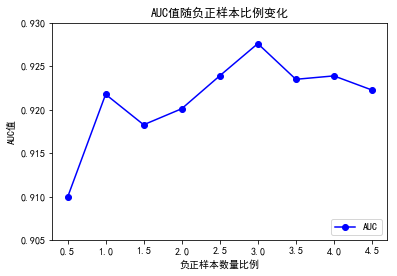

In [26]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.905, 0.93])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/sdneNegSample_auc变化曲线.svg")
plt.show()

In [45]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度
struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    train_data_file="train_data/struct_connective_negPosRatio"+str(sampleRatio)+".csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[struct_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleStruct.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9245117491951109, 0.9307926835507354, 0.9344750228802827, 0.9330591975388639, 0.9345307978370012, 0.9357562596897844, 0.9400825260998873, 0.9368654946911656, 0.9387196609561825]
[0.8593630573248408, 0.8530479648385247, 0.8630178871732151, 0.8676433121019108, 0.8756278663463638, 0.8866806802981082, 0.897231187361984, 0.9003974927381134, 0.9036203182544646]
[0.8959668300037693, 0.8559115608019486, 0.8246575342465754, 0.7937264244590033, 0.7726093032541425, 0.7544513457556937, 0.7569304941743672, 0.7291623363126168, 0.7183756345177665]


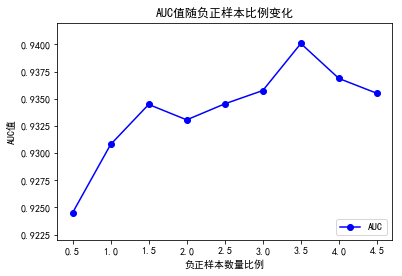

In [70]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.922, 0.942])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/structNegSample_auc变化曲线.svg")
plt.show()

In [39]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
struct_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:    
    connectiveSample_edges = filePredix+str(sampleRatio)+".txt"
    struct_data_file="train_data/struct_connective_negPosRatio"+str(sampleRatio)+".csv"
    pos_edges, neg_edges = read_edges(connectiveSample_edges)
#     connectiveSample_node2vec= "embeddings/all_connectiveSample0.1_node2vec128.txt" 
#     connectiveSample_deepwalk= "embeddings/all_connectiveSample0.1_deepwalk128.txt" 
    connectiveSample_line= "embeddings/all_connectiveSample0.1_line128.txt" 
    connectiveSample_sdne="embeddings/all_connectiveSample0.1_sdne128.txt" 
#     node2vec_feature = get_embedding_features(connectiveSample_node2vec, pos_edges, neg_edges)
#     deepwalk_feature = get_embedding_features(connectiveSample_deepwalk, pos_edges, neg_edges)
    line_feature = get_embedding_features(connectiveSample_line, pos_edges, neg_edges)
    sdne_feature = get_embedding_features(connectiveSample_sdne, pos_edges, neg_edges)
    struct_connectiveSample=pd.read_csv(struct_data_file)
    struct_feature = struct_connectiveSample[struct_columns]
    Y=struct_connectiveSample['label']
#     X = np.hstack((struct_feature,deepwalk_feature,node2vec_feature,line_feature,sdne_feature))
    X = np.hstack((struct_feature,line_feature,sdne_feature))
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model,line_feature,sdne_feature,struct_connectiveSample,struct_feature,X,Y,X_train, X_test, y_train, y_test#,node2vec_feature,deepwalk_feature
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/negSampleAllFeature.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9830152345287865, 0.9849326454621788, 0.9860238068107731, 0.984982104730157, 0.9853878453511045, 0.987676094965298, 0.9868754318057743, 0.9869495871228963, 0.986677723693494]
[0.9380891719745222, 0.9363653735906745, 0.9409876165723895, 0.9403821656050956, 0.9459488971391133, 0.9542327536785783, 0.952012909801257, 0.9553585078734138, 0.9576123966367869]
[0.9543318925014095, 0.9353272480093222, 0.925597532767926, 0.9104134762633996, 0.9020383930338413, 0.9041041041041041, 0.8911158219310079, 0.8869531552458382, 0.8803921568627452]


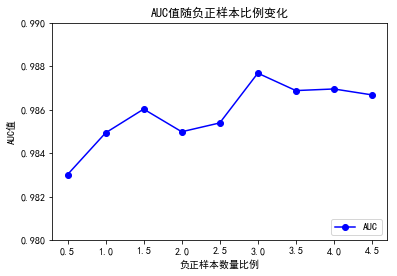

In [40]:
plt.title('AUC值随负正样本比例变化')
plt.plot(negRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.98, 0.99])
plt.ylabel('AUC值')
plt.xlabel('负正样本数量比例')
plt.savefig("pictures/allFeatureNegSample_auc变化曲线.svg")
plt.show()

In [3]:
# G_connect=nx.read_adjlist("network_edgelist/all_network_adjlist_connective.txt")
# trainEdgeFile_connect="network_edgelist/connectiveSample_edges0.5.txt"
# savePath_connect="train_data/struct_connective_traindata.csv"
# struct_train_data_connect=extract_struct_feature(G_connect,trainEdgeFile_connect,savePath_connect)

# G_random=nx.read_adjlist("network_edgelist/all_network_adjlist_random.txt")
# trainEdgeFile_random="network_edgelist/randomSample_edges0.5.txt"
# savePath_random="train_data/struct_random_traindata.csv"
# struct_train_data_random=extract_struct_feature(G_random,trainEdgeFile_random,savePath_random)

In [5]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
    connectiveSample_edges = "network_edgelist/connectiveSample_edges"+str(sampleRatio)+".txt"
    struct_data_file="train_data/struct_connective_traindata"+str(sampleRatio)+".csv"  
    pos_edges, neg_edges = read_edges(connectiveSample_edges)
#     connectiveSample_node2vec= "embeddings/all_connectiveSample"+str(sampleRatio)+"_node2vec128.txt"
#     connectiveSample_deepwalk= "embeddings/all_connectiveSample"+str(sampleRatio)+"_deepwalk128.txt"
    connectiveSample_line= "embeddings/all_connectiveSample"+str(sampleRatio)+"_line128.txt"
    connectiveSample_sdne= "embeddings/all_connectiveSample"+str(sampleRatio)+"_sdne128.txt"
#     node2vec_feature = get_embedding_features(connectiveSample_node2vec, pos_edges, neg_edges)
#     deepwalk_feature = get_embedding_features(connectiveSample_deepwalk, pos_edges, neg_edges)
    line_feature = get_embedding_features(connectiveSample_line, pos_edges, neg_edges)
    sdne_feature = get_embedding_features(connectiveSample_sdne, pos_edges, neg_edges)
    struct_connectiveSample=pd.read_csv(struct_data_file)
    struct_feature = struct_connectiveSample[struct_columns]
    Y=struct_connectiveSample['label']
#     X = np.hstack((struct_feature,deepwalk_feature,node2vec_feature,line_feature,sdne_feature))
    X = np.hstack((struct_feature,line_feature,sdne_feature))
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model,line_feature,sdne_feature,struct_connectiveSample,struct_feature,X,Y,X_train, X_test, y_train, y_test#,node2vec_feature,deepwalk_feature
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleAllFeature.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.98869272320729, 0.9865754204274481, 0.9854255369910584, 0.9868218860949518, 0.9858834147571247, 0.9843719216831892, 0.981245105204192, 0.9782219100747248, 0.9721777878933866]
[0.9455379323523792, 0.9425759602522453, 0.9392317982037073, 0.9410472004586279, 0.9386561687815319, 0.9366818485842596, 0.9284739284739285, 0.9222941499653632, 0.9118821131306268]
[0.9445201479462721, 0.9423501199040768, 0.9396660763976726, 0.9413386575394562, 0.9389339116539207, 0.9368206953537151, 0.928614244455343, 0.923402952742, 0.9138002658690595]


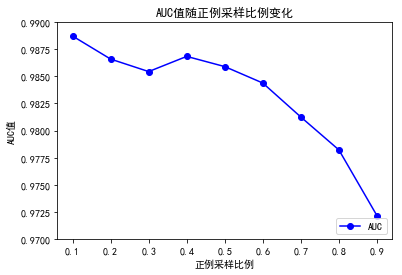

In [7]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.97, 0.99])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/allFeature_auc变化曲线.svg")
plt.show()

In [8]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
    connectiveSample_edges = "network_edgelist/connectiveSample_edges"+str(sampleRatio)+".txt"
    struct_data_file="train_data/struct_connective_traindata"+str(sampleRatio)+".csv"  
    pos_edges, neg_edges = read_edges(connectiveSample_edges)
    connectiveSample_node2vec= "embeddings/all_connectiveSample"+str(sampleRatio)+"_node2vec128.txt"
    connectiveSample_deepwalk= "embeddings/all_connectiveSample"+str(sampleRatio)+"_deepwalk128.txt"
    connectiveSample_line= "embeddings/all_connectiveSample"+str(sampleRatio)+"_line128.txt"
    connectiveSample_sdne= "embeddings/all_connectiveSample"+str(sampleRatio)+"_sdne128.txt"
    node2vec_feature = get_embedding_features(connectiveSample_node2vec, pos_edges, neg_edges)
    deepwalk_feature = get_embedding_features(connectiveSample_deepwalk, pos_edges, neg_edges)
    line_feature = get_embedding_features(connectiveSample_line, pos_edges, neg_edges)
    sdne_feature = get_embedding_features(connectiveSample_sdne, pos_edges, neg_edges)
    struct_connectiveSample=pd.read_csv(struct_data_file)
    struct_feature = struct_connectiveSample[struct_columns]
    Y=struct_connectiveSample['label']
    X = np.hstack((struct_feature,deepwalk_feature,node2vec_feature,line_feature,sdne_feature))
#     X = np.hstack((struct_feature,line_feature,sdne_feature))
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model,line_feature,sdne_feature,struct_connectiveSample,struct_feature,X,Y,X_train, X_test, y_train, y_test,node2vec_feature,deepwalk_feature
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleAllFeature.csv")
print(aucs)
print(accuracys)
print(f1s)

MemoryError: 

In [31]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    train_data_file="train_data/struct_connective_traindata"+str(sampleRatio)+".csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleStruct.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9339836657303167, 0.93727327875907, 0.9326795436905905, 0.9311963780213149, 0.9272006241966613, 0.9235466433513853, 0.9186064403130147, 0.9077528947350402, 0.8835825166006259]
[0.8576342442193771, 0.8591630040129945, 0.8520287916427798, 0.8479361742786165, 0.8444427457575294, 0.8407491161575946, 0.8321321321321321, 0.8192198361321453, 0.7949295056905045]
[0.8588747868914567, 0.859645781755856, 0.8522358628585968, 0.8484213533977809, 0.845258915671812, 0.8426188227887945, 0.8346909697018576, 0.8242044134727062, 0.8055566740487216]


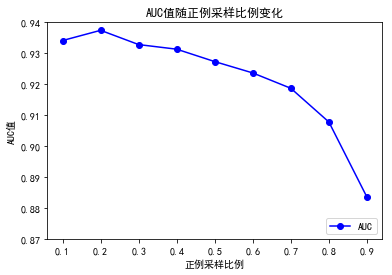

In [35]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.87, 0.94])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/struct_auc变化曲线.svg")
plt.show()

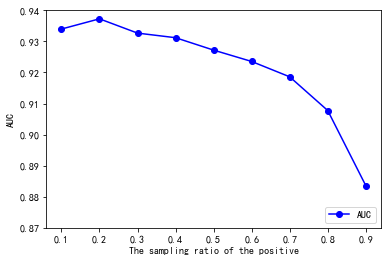

In [39]:
#plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, line_result['roc_auc'], 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.87, 0.94])
plt.ylabel('AUC')
plt.xlabel('The sampling ratio of the positive')
plt.savefig("pictures/struct_auc变化曲线(英文).svg")
plt.show()

In [27]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    train_data_file="train_data/all_connectiveSample"+str(sampleRatio)+"_node2vec128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleNode2vec.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9031027854095951, 0.9153941003111036, 0.9168789450606183, 0.9246731276847396, 0.9327595358809189, 0.9330821648200132, 0.9345050885925505, 0.9398482362077382, 0.9406688719015721]
[0.8192241544047392, 0.8330785400343971, 0.8366137970571373, 0.8446397859736289, 0.8543418437547775, 0.8525336815619327, 0.8543816543816544, 0.8618111458806106, 0.8651477832512315]
[0.8243594504270331, 0.8379255960664255, 0.8390537742360545, 0.8483067450321858, 0.8562917153738828, 0.8541824137062232, 0.8572575465639048, 0.8648774904818629, 0.8694365067944]


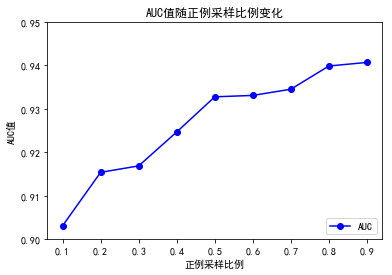

In [28]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.90, 0.95])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/node2vec_auc变化曲线.svg")
plt.show()

In [40]:
#plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, node2vec_result['roc_auc'], 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.87, 0.94])
plt.ylabel('AUC')
plt.xlabel('The sampling ratio of the positive')
plt.savefig("pictures/node2vec_auc变化曲线(英文).svg")
plt.show()

NameError: name 'node2vec_result' is not defined

In [25]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    train_data_file="train_data/all_connectiveSample"+str(sampleRatio)+"_deepwalk128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleDeepwalk.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9030819829792133, 0.9129408169516019, 0.9202590053969683, 0.9280363077614012, 0.933629040740481, 0.9357247825022917, 0.9363112697823088, 0.9386542950526592, 0.9414598870340647]
[0.8106248805656411, 0.8283967131664437, 0.8380151602012867, 0.8498471240206382, 0.8551826937777098, 0.8544446921680415, 0.8575757575757575, 0.8611184100518358, 0.8652964158314931]
[0.8138267894044712, 0.8320867614061331, 0.8409929344088037, 0.8535209954793307, 0.856623907367465, 0.8570266549868603, 0.860735164571154, 0.8638152347043943, 0.8695026124161765]


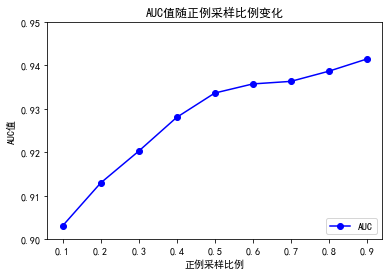

In [26]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.90, 0.95])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/deepwalk_auc变化曲线.svg")
plt.show()

In [5]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    train_data_file="train_data/all_connectiveSample"+str(sampleRatio)+"_line128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleLine.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9588660859768761, 0.9613711004161563, 0.9615107276716685, 0.9579892066746559, 0.9568477343343615, 0.9544895045949299, 0.9540671375016316, 0.9506607947161622, 0.9488408676919381]
[0.896044334034015, 0.8959487865469138, 0.8947066692145996, 0.8908847697305561, 0.8888166946950008, 0.8836513042647387, 0.8825552825552826, 0.8763824857272532, 0.8763164599966027]
[0.8977443609022556, 0.8949551461367801, 0.8958346461654799, 0.8907595178878898, 0.8888719104557437, 0.8842412143106126, 0.8836101942535577, 0.8788311597087264, 0.8795865633074934]


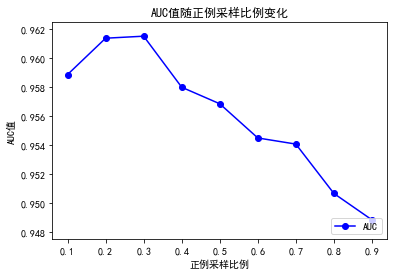

In [17]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.9475, 0.9625])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/line_auc变化曲线.svg")
plt.show()

In [21]:
fprs=[]
tprs=[]
aucs=[]
accuracys=[]
f1s=[]
precisions=[]
recalls=[]
test_size = 0.2
representation_size=128 #表征向量的长度
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:    
    train_data_file="train_data/all_connectiveSample"+str(sampleRatio)+"_sdne128.csv"
    # model =XGBClassifier()#SVC()# LogisticRegression()
    model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
    
    train_data = pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    feature_columns = [str(i) for i in range(representation_size*2)]
    X = train_data[feature_columns]
    Y = train_data['label']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    # y_test_prob.shape=[n_samples, n_classes]
    y_test_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)  # recall得到的是一个list，是每一类的召回率

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    accuracys.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    del model 
    count=gc.collect()
data_dict = {'roc_auc':aucs,'accuracy':accuracys,'f1s':f1s,'precision':precisions,'recalls':recalls,'fprs':fprs,'tprs':tprs}
line_result = pd.DataFrame(data_dict)
line_result.to_csv("result/posSampleSDNE.csv")
print(aucs)
print(accuracys)
print(f1s)

[0.9092420580902485, 0.9254327728342696, 0.9294521005942946, 0.9325407927238096, 0.9332506993211078, 0.9360099160950487, 0.9358881905768321, 0.9369900795301578, 0.9312194693876882]
[0.8171221096885152, 0.8432065736671126, 0.8487801770813428, 0.8520924899675139, 0.8555266778780003, 0.8595407204509985, 0.8578760578760579, 0.8607600984162626, 0.8556140648887379]
[0.8167017812679563, 0.8463627001217116, 0.8504095778197859, 0.853409090909091, 0.8585858585858586, 0.8622993817523262, 0.8604289544235925, 0.8637351847955679, 0.8598400527660978]


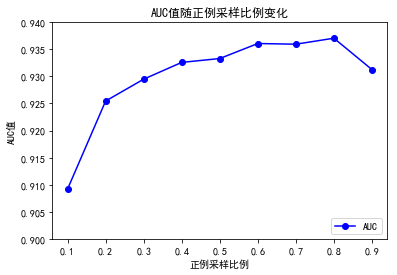

In [24]:
plt.title('AUC值随正例采样比例变化')
plt.plot(posSampleRatio, aucs, 'b-o', label='AUC')
plt.legend(loc='lower right')
plt.ylim([0.90, 0.94])
plt.ylabel('AUC值')
plt.xlabel('正例采样比例')
plt.savefig("pictures/sdne_auc变化曲线.svg")
plt.show()

In [2]:
fpr_connect=[]
fpr_random=[]
tpr_connect=[]
tpr_random=[]

In [3]:
print("all_connectiveSample_node2vec128:")
test_size = 0.2
representation_size=128 #表征向量的长度
# model =XGBClassifier()#SVC()# LogisticRegression()
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_connectiveSample_node2vec128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model 
count=gc.collect()
print("\nall_randomSample_node2vec128:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_randomSample_node2vec128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model 
count=gc.collect()

all_connectiveSample_node2vec128:
roc_auc:0.9352093695479267
accuracy:0.8551826937777098
f1:0.8583710238104139
precision:0.8470675027665068
recall:0.8699803000454615

all_randomSample_node2vec128:
roc_auc:0.9273177229240213
accuracy:0.8449396116801712
f1:0.8474181052314868
precision:0.8303972875359328
recall:0.8651512824450929


In [4]:
print("all_connectiveSample_deepwalk128:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_connectiveSample_deepwalk128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model 
count=gc.collect()
print("\nall_randomSample_deepwalk128:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_randomSample_deepwalk128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model 
count=gc.collect()

all_connectiveSample_deepwalk128:
roc_auc:0.9327172522237134
accuracy:0.8543800642103654
f1:0.856085215683312
precision:0.8425905271767418
recall:0.8700191938579654

all_randomSample_deepwalk128:
roc_auc:0.9262208337345815
accuracy:0.8485323345054273
f1:0.8496300512236767
precision:0.8385888697475844
recall:0.8609658566594894


In [5]:
print("Line connection:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_connectiveSample_line128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model 
count=gc.collect()
print("\nLine random:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_randomSample_line128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model 
count=gc.collect()

Line connection:
roc_auc:0.9591414555963576
accuracy:0.8901926310961626
f1:0.8911866075824717
precision:0.8829268292682927
recall:0.8996023856858847

Line random:
roc_auc:0.9630130937322936
accuracy:0.8980660449472557
f1:0.8973006276714545
precision:0.8943732248407155
recall:0.9002472569927368


In [6]:
print("Sdne connection:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_connectiveSample_sdne128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model 
count=gc.collect()
print("\nSdne random:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/all_randomSample_sdne128.csv"
fpr, tpr=run_embedding(model,train_data_file,representation_size,test_size)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model 
count=gc.collect()

Sdne connection:
roc_auc:0.9356477396654967
accuracy:0.8593105029811955
f1:0.8616841393304024
precision:0.8489560195468681
recall:0.8747997253376059

Sdne random:
roc_auc:0.9280710548534894
accuracy:0.8536538755541966
f1:0.8550554567134799
precision:0.8499397953040337
recall:0.8602330718257293


In [7]:
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
print("Struct connection:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/struct_connective_traindata.csv"
fpr, tpr=run_struct(model,train_data_file,feature_columns,test_size)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model 
count=gc.collect()
print("\nStruct random:")
test_size = 0.2
representation_size=128 #表征向量的长度
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
train_data_file="train_data/struct_random_traindata.csv"
fpr, tpr=run_struct(model,train_data_file,feature_columns,test_size)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model 
count=gc.collect()

Struct connection:
roc_auc:0.927572700797699
accuracy:0.8462008867145696
f1:0.8485281939320937
precision:0.8389906208128629
recall:0.8582851050868109

Struct random:
roc_auc:0.9200249753544912
accuracy:0.8393594251643479
f1:0.8374898503653869
precision:0.8397952853598015
recall:0.8351970386365389


In [8]:
# 基于边的特征
struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
connectiveSample_edges = "network_edgelist/connectiveSample_edges0.5.txt"
pos_edges, neg_edges = read_edges("network_edgelist/connectiveSample_edges0.5.txt")
print("All feature connection:\n")
connectiveSample_node2vec= "embeddings/all_connectiveSample_node2vec128.txt"
connectiveSample_deepwalk= "embeddings/all_connectiveSample_deepwalk128.txt"
connectiveSample_line= "embeddings/all_connectiveSample_line128.txt"
connectiveSample_sdne= "embeddings/all_connectiveSample_sdne128.txt"
node2vec_feature = get_embedding_features(connectiveSample_node2vec, pos_edges, neg_edges)
deepwalk_feature = get_embedding_features(connectiveSample_deepwalk, pos_edges, neg_edges)
line_feature = get_embedding_features(connectiveSample_line, pos_edges, neg_edges)
sdne_feature = get_embedding_features(connectiveSample_sdne, pos_edges, neg_edges)
struct_connectiveSample=pd.read_csv("train_data/struct_connective_traindata.csv")
struct_feature = struct_connectiveSample[struct_columns]
Y=struct_connectiveSample['label']
X = np.hstack((struct_feature,deepwalk_feature,node2vec_feature,line_feature,sdne_feature))
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)
fpr_connect.append(fpr)
tpr_connect.append(tpr)
del model,node2vec_feature,deepwalk_feature,line_feature,sdne_feature,struct_connectiveSample,struct_feature,X,Y,X_train, X_test, y_train, y_test
count=gc.collect()

All feature connection:

roc_auc:0.985447422995946
accuracy:0.9381975233144779
f1:0.9386547289350886
precision:0.9326749095295537
recall:0.9447117220313097


In [9]:
struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
pos_edges, neg_edges = read_edges("network_edgelist/randomSample_edges0.5.txt")
print("\nAll feature random:\n")
randomSample_node2vec= "embeddings/all_randomSample_node2vec128.txt"
randomSample_deepwalk= "embeddings/all_randomSample_deepwalk128.txt"
randomSample_line= "embeddings/all_randomSample_line128.txt"
randomSample_sdne= "embeddings/all_randomSample_sdne128.txt"
node2vec_feature = get_embedding_features(randomSample_node2vec, pos_edges, neg_edges)
deepwalk_feature = get_embedding_features(randomSample_deepwalk, pos_edges, neg_edges)
line_feature = get_embedding_features(randomSample_line, pos_edges, neg_edges)
sdne_feature = get_embedding_features(randomSample_sdne, pos_edges, neg_edges)
struct_randomSample=pd.read_csv("train_data/struct_random_traindata.csv")
struct_feature = struct_randomSample[struct_columns]
Y=struct_randomSample['label']
X = np.hstack((struct_feature,deepwalk_feature,node2vec_feature,line_feature,sdne_feature))
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)
fpr_random.append(fpr)
tpr_random.append(tpr)
del model,node2vec_feature,deepwalk_feature,line_feature,sdne_feature,struct_randomSample,struct_feature,X,Y,X_train, X_test, y_train, y_test
count=gc.collect()


All feature random:

roc_auc:0.9847388100244273
accuracy:0.9378535392141875
f1:0.9381796061136035
precision:0.9342015597789052
recall:0.9421916762122947


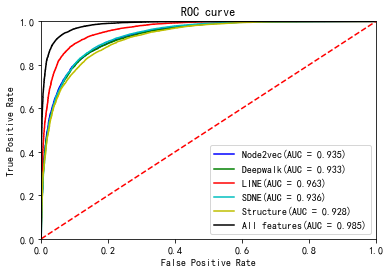

In [10]:
featureNames=["Node2vec","Deepwalk","LINE","SDNE","Structure","All features"]
colors=["b","g","r","c","y","k"]
savaPath="pictures/pos_sample_connect_roc_english.svg"
plt.title('ROC curve')
for i in range(len(featureNames)):
    roc_auc=metrics.auc(fpr_connect[i],tpr_connect[i])
    plt.plot(fpr_connect[i],tpr_connect[i], colors[i], label=featureNames[i]+str('(AUC = %0.3f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(savaPath)
plt.show()

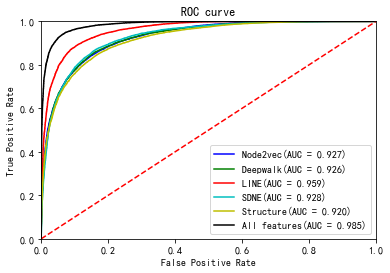

In [11]:
featureNames=["Node2vec","Deepwalk","LINE","SDNE","Structure","All features"]
colors=["b","g","r","c","y","k"]
savaPath="pictures/pos_sample_random_roc_english.svg"
plt.title('ROC curve')
for i in range(len(featureNames)):
    roc_auc=metrics.auc(fpr_random[i],tpr_random[i])
    plt.plot(fpr_random[i],tpr_random[i], colors[i], label=featureNames[i]+str('(AUC = %0.3f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(savaPath)
plt.show()

roc_auc:0.9715644496355599
accuracy:0.9096086225347806
f1:0.9097775912715065
precision:0.9089800274432078
recall:0.9105765559373806


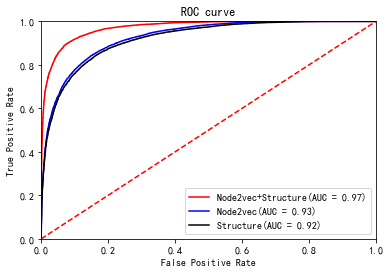

In [12]:
randomSample_embedding = "embeddings/all_randomSample_node2vec128.txt"
embedding_feature = get_embedding_features(
    randomSample_embedding, pos_edges, neg_edges)
struct_randomSample = pd.read_csv("train_data/struct_random_traindata.csv")
struct_feature = struct_randomSample[struct_columns]
Y = struct_randomSample['label']
X = np.hstack((struct_feature, embedding_feature))
model = LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.1, n_estimators=100, objective='binary', min_split_gain=0.0,
                       min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)

# structure
plt.title('ROC curve')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label="Node2vec+Structure" + str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[0], tpr_random[0])
plt.plot(fpr_random[0], tpr_random[0], 'b', label="Node2vec"+str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[4], tpr_random[4])
plt.plot(fpr_random[4], tpr_random[4], 'k',label="Structure"+str('(AUC = %0.2f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_node2vec_roc_english.svg")
plt.show()
del model, embedding_feature, struct_randomSample, struct_feature, X, Y, X_train, X_test, y_train, y_test
count = gc.collect()

roc_auc:0.9717081226962563
accuracy:0.911099220302706
f1:0.9113296736810004
precision:0.9098728781304712
recall:0.912791141657121


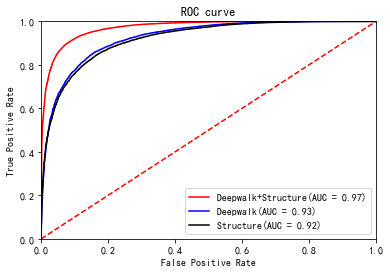

In [13]:
randomSample_embedding = "embeddings/all_randomSample_deepwalk128.txt"
embedding_feature = get_embedding_features(randomSample_embedding, pos_edges, neg_edges)
struct_randomSample = pd.read_csv("train_data/struct_random_traindata.csv")
struct_feature = struct_randomSample[struct_columns]
Y = struct_randomSample['label']
X = np.hstack((struct_feature, embedding_feature))
model = LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.1, n_estimators=100, objective='binary', min_split_gain=0.0,
                       min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)
# structure
plt.title('ROC curve')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label="Deepwalk+Structure" +str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[1], tpr_random[1])
plt.plot(fpr_random[1], tpr_random[1], 'b',label="Deepwalk"+str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[4], tpr_random[4])
plt.plot(fpr_random[4], tpr_random[4], 'k',label="Structure"+str('(AUC = %0.2f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_deepwalk_roc_english.svg")
plt.show()
del model, embedding_feature, struct_randomSample, struct_feature, X, Y, X_train, X_test, y_train, y_test
count = gc.collect()

roc_auc:0.9843115421887254
accuracy:0.9353309891453906
f1:0.9356800729871513
precision:0.9315721747028991
recall:0.9398243604429172


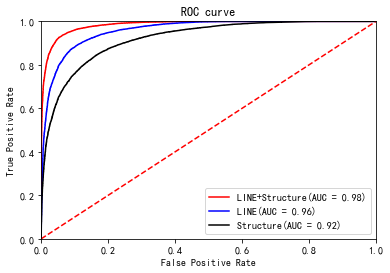

In [17]:
randomSample_embedding = "embeddings/all_randomSample_line128.txt"
embedding_feature = get_embedding_features(randomSample_embedding, pos_edges, neg_edges)
struct_randomSample = pd.read_csv("train_data/struct_random_traindata.csv")
struct_feature = struct_randomSample[struct_columns]
Y = struct_randomSample['label']
X = np.hstack((struct_feature, embedding_feature))
model = LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.1, n_estimators=100, objective='binary', min_split_gain=0.0,
                       min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)
# structure
plt.title('ROC curve')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label="LINE+Structure" +str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[2], tpr_random[2])
plt.plot(fpr_random[2], tpr_random[2], 'b',label="LINE"+str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[4], tpr_random[4])
plt.plot(fpr_random[4], tpr_random[4], 'k',label="Structure"+str('(AUC = %0.2f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_line_roc_english.svg")
plt.show()
del model, embedding_feature, struct_randomSample, struct_feature, X, Y, X_train, X_test, y_train, y_test
count = gc.collect()

roc_auc:0.9744857551239696
accuracy:0.9161825408958875
f1:0.9163264527452402
precision:0.9156626506024096
recall:0.9169912180221459


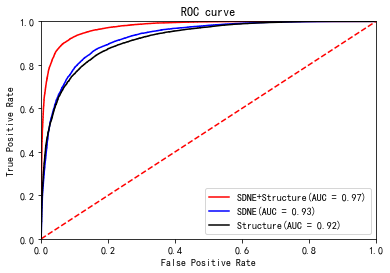

In [15]:
randomSample_embedding = "embeddings/all_randomSample_sdne128.txt"
embedding_feature = get_embedding_features(randomSample_embedding, pos_edges, neg_edges)
struct_randomSample = pd.read_csv("train_data/struct_random_traindata.csv")
struct_feature = struct_randomSample[struct_columns]
Y = struct_randomSample['label']
X = np.hstack((struct_feature, embedding_feature))
model = LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.1, n_estimators=100, objective='binary', min_split_gain=0.0,
                       min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)
# structure
plt.title('ROC curve')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label="SDNE+Structure" +str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[3], tpr_random[3])
plt.plot(fpr_random[3], tpr_random[3], 'b',label="SDNE"+str('(AUC = %0.2f)' % roc_auc))
roc_auc = metrics.auc(fpr_random[4], tpr_random[4])
plt.plot(fpr_random[4], tpr_random[4], 'k',label="Structure"+str('(AUC = %0.2f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_sdne_roc_english.svg")
plt.show()
del model, embedding_feature, struct_randomSample, struct_feature, X, Y, X_train, X_test, y_train, y_test
count = gc.collect()

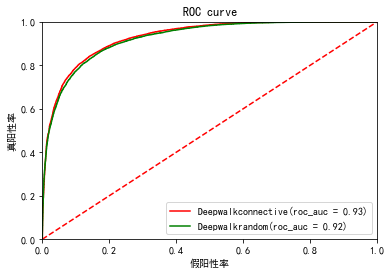

In [64]:
#Deepwalk
featureNames=["Node2vec","Deepwalk","Line","SDNE","Structure"]
colors=["b","g","r","k","RoyalBlue"]
plt.title('ROC curve')
roc_auc=metrics.auc(fpr_connect[1],tpr_connect[1])
plt.plot(fpr_connect[1],tpr_connect[1], colors[2], label=featureNames[1]+"connective"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[1],tpr_random[1])
plt.plot(fpr_random[1],tpr_random[1], colors[1], label=featureNames[1]+"random"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

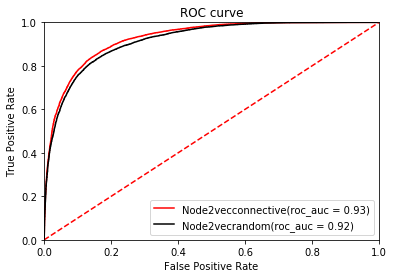

In [67]:
#node2vec
plt.title('ROC curve')
roc_auc=metrics.auc(fpr_connect[0],tpr_connect[0])
plt.plot(fpr_connect[0],tpr_connect[0], colors[2], label=featureNames[0]+"connective"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[0],tpr_random[0])
plt.plot(fpr_random[0],tpr_random[0], colors[3], label=featureNames[0]+"random"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/pos_sample_node2vec_roc.svg")
plt.show()

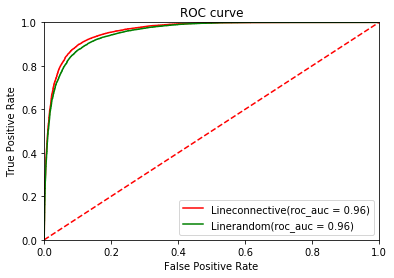

In [62]:
#Line
plt.title('ROC curve')
roc_auc=metrics.auc(fpr_connect[2],tpr_connect[2])
plt.plot(fpr_connect[2],tpr_connect[2], colors[2], label=featureNames[2]+"connective"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[2],tpr_random[2])
plt.plot(fpr_random[2],tpr_random[2], colors[1], label=featureNames[2]+"random"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

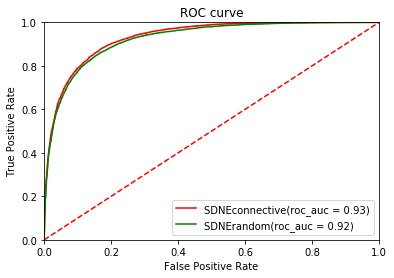

In [63]:
#SDNE
plt.title('ROC curve')
roc_auc=metrics.auc(fpr_connect[3],tpr_connect[3])
plt.plot(fpr_connect[3],tpr_connect[3], colors[2], label=featureNames[3]+"connective"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[3],tpr_random[3])
plt.plot(fpr_random[3],tpr_random[3], colors[1], label=featureNames[3]+"random"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

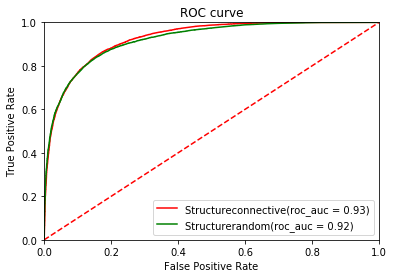

In [64]:
#structure
plt.title('ROC curve')
roc_auc=metrics.auc(fpr_connect[4],tpr_connect[4])
plt.plot(fpr_connect[4],tpr_connect[4], colors[2], label=featureNames[4]+"connective"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[4],tpr_random[4])
plt.plot(fpr_random[4],tpr_random[4], colors[1], label=featureNames[4]+"random"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
ramdomSample_edges = "network_edgelist/randomSample_edges0.5.txt"
pos_edges, neg_edges = read_edges("network_edgelist/randomSample_edges0.5.txt")
# 基于边的特征
struct_columns = ["degree1", "degree2", "centrality1", "centrality2", "cluster_coefficient1",
                  "cluster_coefficient2", "resource_allocation", "jaccard_coefficient", "preferential_attachment"]
struct_feature = struct_train_data_ramdom[struct_columns]
Y = struct_train_data_connect['label']
# fpr_struct, tpr_struct=fpr_connect[4],tpr_connect[4]
# roc_auc_struct=metrics.auc(fpr_struct,tpr_struct)

In [12]:
randomSample_embedding = "embeddings/all_randomSample_node2vec128.txt"
embedding_feature = get_embedding_features(randomSample_embedding, pos_edges, neg_edges)
X = np.hstack((struct_features, embedding_feature))
model = LGBMClassifier(boosting_type='gbdt',num_leaves=200,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='binary', min_split_gain=0.0,
    min_child_samples=20,subsample=1.0,subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,random_state=None, silent=True)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
fpr, tpr = all_metric(model, X_test, y_test)


#structure
plt.title('ROC curve')
roc_auc_struct=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr, 'r', label="structure+node2vec"+str('(roc_auc = %0.2f)' % roc_auc_struct))
roc_auc=metrics.auc(fpr_random[0],tpr_random[0])
plt.plot(fpr_randomt[0],tpr_random[0], 'b', label="node2vec"+str('(roc_auc = %0.2f)' % roc_auc))

roc_auc=metrics.auc(fpr_random[4],tpr_random[4])
plt.plot(fpr_random[4],tpr_random[4], 'b', label="node2vec"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_node2vec_roc.svg")
plt.show()

NameError: name 'struct_features' is not defined

57358 128
Accuracy: 87.28%
f1:0.8737724187616122
roc_auc:0.945470463975812
recall:0.8798778159602901
precision:0.8677511673444795


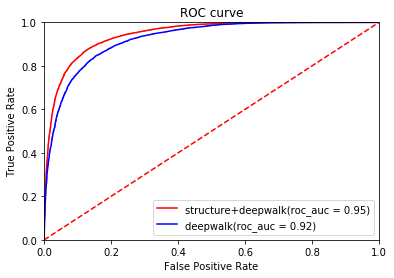

In [76]:
connectiveSample_embedding = "embeddings/all_randomSample_deepwalk128.txt"
embedding_feature = get_embedding_features(connectiveSample_embedding, pos_edges, neg_edges)
X = np.hstack((struct_features, embedding_feature))
model = XGBClassifier()  # SVC()# LogisticRegression()
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
fpr, tpr = all_metric(model, X_test, y_test)
#structure
plt.title('ROC curve')
roc_auc_struct=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr, 'r', label="structure+deepwalk"+str('(roc_auc = %0.2f)' % roc_auc_struct))
roc_auc=metrics.auc(fpr_connect[1],tpr_connect[1])
plt.plot(fpr_connect[1],tpr_connect[1], 'b', label="deepwalk"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_deepwalk_roc.svg")
plt.show()

57358 128
Accuracy: 90.53%
f1:0.9054847814478603
roc_auc:0.9673251097626717
recall:0.9064528445971745
precision:0.9045187838146765


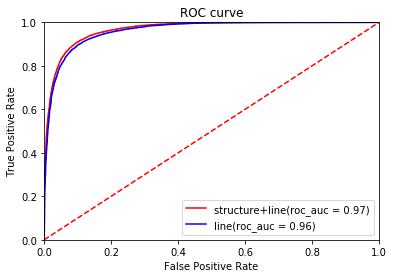

In [75]:
connectiveSample_embedding = "embeddings/all_connectiveSample_line128.txt"
embedding_feature = get_embedding_features(connectiveSample_embedding, pos_edges, neg_edges)
X = np.hstack((struct_features, embedding_feature))
model = XGBClassifier()  # SVC()# LogisticRegression()

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
fpr, tpr = all_metric(model, X_test, y_test)


#structure
plt.title('ROC curve')
roc_auc_struct=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr, 'r', label="structure+line"+str('(roc_auc = %0.2f)' % roc_auc_struct))
roc_auc=metrics.auc(fpr_connect[2],tpr_connect[2])
plt.plot(fpr_connect[2],tpr_connect[2], 'b', label="line"+str('(roc_auc = %0.2f)' % roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_line_roc.svg")
plt.show()

57358 128
Accuracy: 87.34%
f1:0.8743028417498198
roc_auc:0.9467263761809839
recall:0.8798778159602901
precision:0.8687980696727492


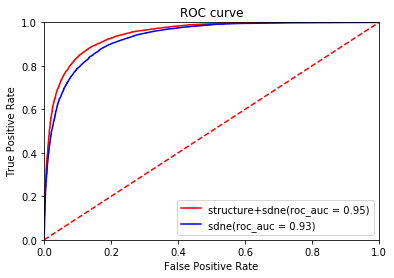

In [74]:
connectiveSample_embedding = "embeddings/all_connectiveSample_sdne128.txt"
embedding_feature = get_embedding_features(connectiveSample_embedding, pos_edges, neg_edges)
X = np.hstack((struct_features, embedding_feature))
model = XGBClassifier()  # SVC()# LogisticRegression()
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
fpr, tpr = all_metric(model, X_test, y_test)

#structure
plt.title('ROC curve')
roc_auc_struct=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr, 'r', label="structure+sdne"+str('(roc_auc = %0.2f)' % roc_auc_struct))
roc_auc=metrics.auc(fpr_connect[3],tpr_connect[3])
plt.plot(fpr_connect[3],tpr_connect[3], 'b', label="sdne"+str('(roc_auc = %0.2f)' % roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("pictures/struct_sdne_roc.svg")
plt.show()